In [163]:
# !pip install statsforecast
# !pip install fugue
!pip install prophet
# !pip install numpy==1.23.5

     |████████████████████████████████| 8.9 MB 4.5 MB/s            
     |████████████████████████████████| 83 kB 623 kB/s            
     |████████████████████████████████| 208 kB 3.9 MB/s            
     |████████████████████████████████| 47 kB 1.2 MB/s            
     |████████████████████████████████| 5.8 MB 5.0 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 1.8 MB 7.6 MB/s            
Using legacy 'setup.py install' for pymeeus, since package 'wheel' is not installed.
    Running setup.py install for pymeeus ... done


In [1]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
import os
# from statsforecast.distributed.utils import forecast
# from statsforecast.distributed.fugue import FugueBackend
# from statsforecast.models import *
# from statsforecast.core import *
import prophet
from datetime import timedelta
from pyspark.sql.functions import pandas_udf, PandasUDFType

/opt/bitnami/python/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
spark = SparkSession.builder.appName("Vu dep trai").config("spark.executor.memory","10g").getOrCreate()
# conf = pyspark.SparkConf().setMaster("spark://node-master:7077")\
#         .setAppName("Vu dep trai")\
#         .set("spark.executor.memory","15g")
# # sc = SparkContext.getOrCreate(conf=conf)
# sc = SparkContext(conf = conf)
# spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/11 08:38:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [49]:
list_ticker = list(os.listdir("./raw_data/"))
list_ticker.sort()
ticker = list_ticker[2]

df = spark.read.json("./raw_data/"+ticker)
df = df.withColumn("trading_date", to_utc_timestamp("trading_date", "GMT+7"))
df = df.withColumn("trading_date", df["trading_date"].cast(DateType()))
df = df.withColumnRenamed("ticker_name", "unique_id").sort("trading_date")

In [50]:
df.show(10)

+-----------+----------+---------+----------+---------+------------+------+
|close_price|high_price|low_price|open_price|unique_id|trading_date|volume|
+-----------+----------+---------+----------+---------+------------+------+
|     9094.0|    9094.0|   9094.0|    9094.0|      AAM|  2009-09-23|  5380|
|     9533.0|    9533.0|   9533.0|    9533.0|      AAM|  2009-09-24| 12090|
|     9971.0|    9971.0|   9971.0|    9971.0|      AAM|  2009-09-27|  9150|
|    10470.0|   10470.0|  10470.0|   10470.0|      AAM|  2009-09-28| 11530|
|    10969.0|   10969.0|  10969.0|   10969.0|      AAM|  2009-09-29| 29680|
|    11467.0|   11467.0|  11467.0|   11467.0|      AAM|  2009-09-30|122120|
|    11966.0|   11966.0|  11866.0|   11965.0|      AAM|  2009-10-01|501150|
|    12564.0|   12564.0|  12564.0|   12564.0|      AAM|  2009-10-04|157030|
|    12564.0|   12963.0|  12464.0|   12962.0|      AAM|  2009-10-05|257710|
|    12065.0|   12365.0|  11966.0|   12065.0|      AAM|  2009-10-06|301400|
+-----------

In [51]:
min_date = df.agg({"trading_date": "min"}).collect()[0][0]
max_date = df.agg({"trading_date": "max"}).collect()[0][0]
print("Min date: ", min_date)
print("Max date: ", max_date)

Min date:  2009-09-23
Max date:  2023-02-09


In [52]:
dates = [x + 1 for x in range(0, (int((max_date - min_date).days) + 1))]
dates = [min_date + timedelta(days=x) for x in dates]
dates_array = [d.strftime("%Y-%m-%d") for d in dates]
df_dates = spark.createDataFrame(dates_array, StringType()).withColumnRenamed("value", "trading_date")
df_dates = df_dates.withColumn("trading_date", to_utc_timestamp("trading_date", "GMT+7"))
df_dates = df_dates.withColumn("trading_date", df_dates["trading_date"].cast(DateType()))

In [53]:
df_filled = df_dates.join(df, on=["trading_date"], how="left")
mode_value = df_filled.groupBy("unique_id").count().sort(desc("count")).collect()[0][0]
df_filled = df_filled.fillna(mode_value, subset=["unique_id"])
df_filled.show(10)

+------------+-----------+----------+---------+----------+---------+------+
|trading_date|close_price|high_price|low_price|open_price|unique_id|volume|
+------------+-----------+----------+---------+----------+---------+------+
|  2009-09-23|     9094.0|    9094.0|   9094.0|    9094.0|      AAM|  5380|
|  2009-09-24|     9533.0|    9533.0|   9533.0|    9533.0|      AAM| 12090|
|  2009-09-25|       null|      null|     null|      null|      AAM|  null|
|  2009-09-26|       null|      null|     null|      null|      AAM|  null|
|  2009-09-27|     9971.0|    9971.0|   9971.0|    9971.0|      AAM|  9150|
|  2009-09-28|    10470.0|   10470.0|  10470.0|   10470.0|      AAM| 11530|
|  2009-09-29|    10969.0|   10969.0|  10969.0|   10969.0|      AAM| 29680|
|  2009-09-30|    11467.0|   11467.0|  11467.0|   11467.0|      AAM|122120|
|  2009-10-01|    11966.0|   11966.0|  11866.0|   11965.0|      AAM|501150|
|  2009-10-02|       null|      null|     null|      null|      AAM|  null|
+-----------

In [54]:
def fill_nan_linear(arr: np.ndarray):
    """Fill nan values in a 1D array using linear interpolation."""
    arr = arr.copy()
    nan_idx = np.isnan(arr)
    arr[nan_idx] = np.interp(np.flatnonzero(nan_idx), np.flatnonzero(~nan_idx), arr[~nan_idx])
    return arr

In [55]:
def fill_nan_df(df, column: str):
    """Fill nan values in a column of a dataframe using linear interpolation"""
    df_pd = df.toPandas()
    df_pd[column] = fill_nan_linear(df_pd[column].values)
    return spark.createDataFrame(df_pd)

In [56]:
def plot_result(df_train: pd.DataFrame, df_valid: pd.DataFrame, df_forecast: pd.DataFrame, title: str = None):
    sns.set(rc={'figure.figsize':(11, 4)})
    df_train.set_index("ds").y.plot(linewidth=0.5)
    df_valid.set_index("ds").y.plot(linewidth=0.5, c="red")
    df_forecast.set_index("ds").yhat.plot(linewidth=0.5, c="green")
    plt.fill_between(df_forecast.ds, df_forecast.yhat_lower, df_forecast.yhat_upper, alpha=0.25)
    if title:
        plt.title(title)


In [57]:
def prepare_data(df, date_col, id_col, y_col, ratio=0.8):
    n_train = int(df.count() * ratio)
    n_valid = df.count() - n_train
    df_train = df.orderBy(date_col).limit(n_train)
    df_valid = df.subtract(df_train).orderBy(date_col)

    df_train_spec = df_train.select(date_col, id_col, y_col)
    df_train_spec = df_train_spec.withColumnRenamed(y_col, "y")
    df_train_spec = df_train_spec.withColumnRenamed(date_col, "ds")
    df_train_spec = fill_nan_df(df_train_spec, "y")

    df_valid_spec = df_valid.select(date_col, id_col, y_col)
    df_valid_spec = df_valid_spec.withColumnRenamed(y_col, "y")
    df_valid_spec = df_valid_spec.withColumnRenamed(date_col, "ds")

    return df_train_spec, df_valid_spec, n_train, n_valid

schema = StructType([
                    #  StructField('unique_id', StringType()),
                     StructField('ds', TimestampType()),
                     StructField('yhat', DoubleType()),
                     StructField('yhat_upper', DoubleType()),
                     StructField('yhat_lower', DoubleType()),
])

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def prophet_udf(df):
    m = prophet.Prophet(
        interval_width=0.90,
        growth='linear',
        changepoint_prior_scale=0.1,
        n_changepoints=30,
        seasonality_prior_scale=15,
        seasonality_mode='multiplicative'
    )
    m.fit(df)
    future = m.make_future_dataframe(periods=n_valid, freq='d', include_history=True)
    forecast = m.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/bitnami/spark/python/pyspark/sql/pandas/group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
09:11:07 - cmdstanpy - INFO - Chain [1] start processing            (0 + 1) / 1]
09:11:45 - cmdstanpy - INFO - Chain [1] done processing
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = serie

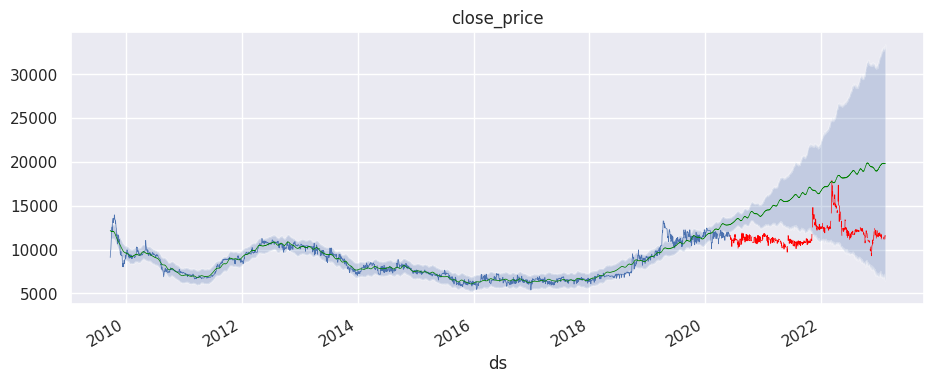

/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/bitnami/spark/python/pyspark/sql/pandas/group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
09:11:54 - cmdstanpy - INFO - Chain [1] start processing
09:12:35 - cmdstanpy - INFO - Chain [1] done processing             (0 + 1) / 1]
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = seri

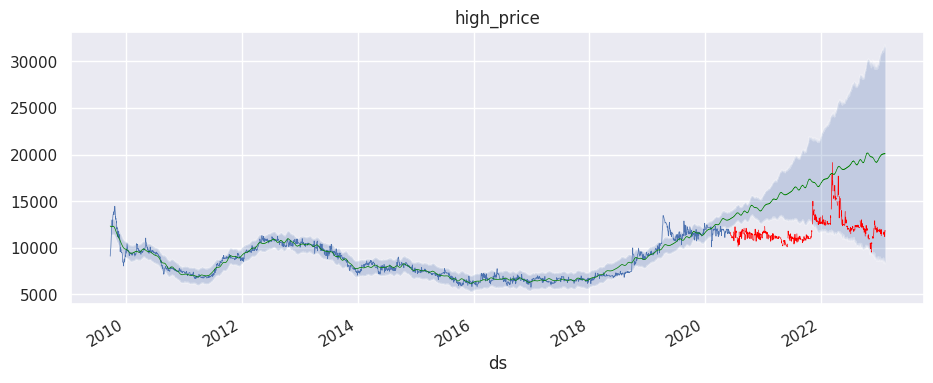

/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/bitnami/spark/python/pyspark/sql/pandas/group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
09:12:43 - cmdstanpy - INFO - Chain [1] start processing
09:13:23 - cmdstanpy - INFO - Chain [1] done processing             (0 + 1) / 1]
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = seri

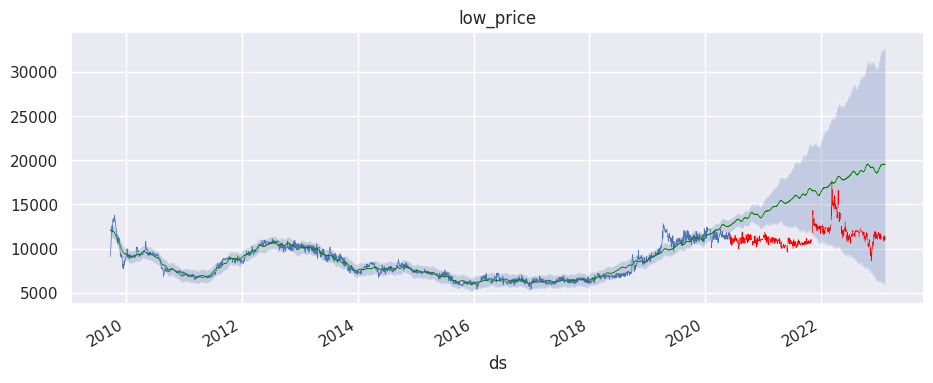

/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/bitnami/spark/python/pyspark/sql/pandas/group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
09:13:32 - cmdstanpy - INFO - Chain [1] start processing                        
09:14:16 - cmdstanpy - INFO - Chain [1] done processing             (0 + 1) / 1]
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]'

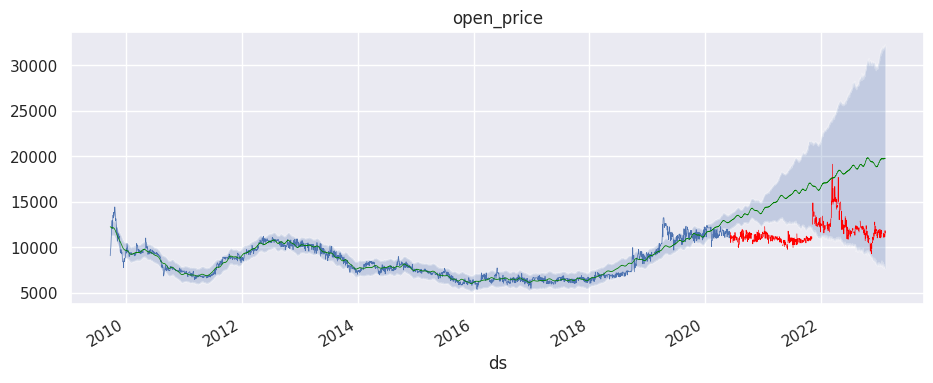

/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/bitnami/spark/python/pyspark/sql/pandas/group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
09:14:26 - cmdstanpy - INFO - Chain [1] start processing
09:15:14 - cmdstanpy - INFO - Chain [1] done processing             (0 + 1) / 1]
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/bitnami/python/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.s

KeyboardInterrupt: 

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 49146)
Traceback (most recent call last):
  File "/opt/bitnami/python/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/bitnami/python/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/bitnami/python/lib/python3.8/socketserver.py", line 360, in finish_request
    self.Req

In [58]:
forecast_attr = ["close_price", "high_price", "low_price", "open_price", "volume"]
for attr in forecast_attr:
    t, v, n_train, n_valid = prepare_data(df_filled, "trading_date", "unique_id", attr)
    df_forecast = t.groupby("unique_id").apply(prophet_udf)
    plot_result(t.toPandas(), v.toPandas(), df_forecast.toPandas(), title=attr)
    plt.show()